In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter

import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle

In [2]:
def filter_butter(data, ordem, freq_corte, freq_amostragem):
    ''' Entrada: Dados que serão filtrados - shape(n,3)'''
    ''' Entrada: Ordem do filtro'''
    ''' Entrada: Frequência de corte do filtro'''
    ''' Entrada: Frequência de amostragem do filtro'''
    ''' Saída: Dados filtrados - shape(n,3)'''
    
    # Criar o filtro
    create_filter = signal.butter(ordem, freq_corte, btype='low', fs=freq_amostragem, output='sos')
    
    # Criar a variável que irá receber os dados filtrados
    data_filter = np.zeros(data.shape)
    
    # Aplicar o filtro
    data_filter[:,0] = signal.sosfiltfilt(create_filter, data[:,0])
    data_filter[:,1] = signal.sosfiltfilt(create_filter, data[:,1])
    data_filter[:,2] = signal.sosfiltfilt(create_filter, data[:,2])
    
    return data_filter  

In [3]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [4]:
''' Alterar o número do Voluntário e a Chave de Repetição'''

voluntary = 52
key = 'S1_Synched'

voluntary = str(voluntary)


''' Alterar o número do Voluntário Referência e a Chave de Repetição Referência'''

ref_voluntary = 15
ref_key = 'S1_Synched'

ref_voluntary = str(ref_voluntary)


In [5]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

In [6]:
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Spine = data.iloc[:,15:18].values
R_0 = ref_data.iloc[:,3:6].values
L_0 = ref_data.iloc[:,6:9].values
S_0 = ref_data.iloc[:,15:18].values

In [7]:
# Definindo a frequência de amostragem
freq_amostragem = 120

# Definindo a ordem do filtro 
ordem = 2

# Definindo frequência de corte do filtro 
freq_corte_Leg = 0.7
freq_corte_Spine = 1.3

In [8]:
# Aplicando filtro com frequência de corte do pescoço, perna direita e perna esquerda.
Spine_filter = filter_butter(Spine, ordem, freq_corte_Spine, freq_amostragem)
RightUpLeg_filter = filter_butter(RightUpLeg, ordem, freq_corte_Leg, freq_amostragem)
LeftUpLeg_filter = filter_butter(LeftUpLeg, ordem, freq_corte_Leg, freq_amostragem)
S_0_filter = filter_butter(S_0, ordem, freq_corte_Spine, freq_amostragem)
R_0_filter = filter_butter(R_0, ordem, freq_corte_Leg, freq_amostragem)
L_0_filter = filter_butter(L_0, ordem, freq_corte_Leg, freq_amostragem)

# Aplicando as transformações de aceleração para os dados de ângulos
angle_rad_Spine_filter, angle_Spine_filter = acc_to_angle(Spine_filter)
angle_rad_RightUpLeg_filter, angle_RightUpLeg_filter = acc_to_angle(RightUpLeg_filter)
angle_rad_LeftUpLeg_filter, angle_LeftUpLeg_filter = acc_to_angle(LeftUpLeg_filter)
angle_rad_Spine_filter, angle_S_0_filter = acc_to_angle(S_0_filter)
angle_rad_RightUpLeg_filter, angle_R_0_filter = acc_to_angle(R_0_filter)
angle_rad_LeftUpLeg_filter, angle_L_0_filter = acc_to_angle(L_0_filter)


# Criando vetor de tempo
t = np.linspace(0, len(angle_RightUpLeg_filter) / freq_amostragem, len(angle_RightUpLeg_filter))

# Criando título das imagens
title_Spine = 'Filtro em ' + str(freq_corte_Spine) + 'Hz'
title_Leg = 'Filtro em ' + str(freq_corte_Leg) + 'Hz'

# RNN com sklearn

In [10]:
from sklearn.neural_network import MLPClassifier

In [11]:
classificador = MLPClassifier(verbose = True, max_iter = 1000, tol = 0.00001)

In [12]:
classes = np.zeros((angle_Spine_filter.shape))
classes[0:140] = 0
classes[140:370] = 1
classes[370:570] = 2
classes[570:830] = 1
classes[830:] = 0
previsores = np.c_[ angle_Spine_filter, angle_RightUpLeg_filter, angle_LeftUpLeg_filter ]

In [13]:
classificador.fit(previsores, classes)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Iteration 1, loss = 8.47043394
Iteration 2, loss = 3.13912132
Iteration 3, loss = 3.02405125
Iteration 4, loss = 1.39744456
Iteration 5, loss = 1.77647372
Iteration 6, loss = 1.38204802
Iteration 7, loss = 1.31826765
Iteration 8, loss = 1.08801283
Iteration 9, loss = 1.08938975
Iteration 10, loss = 1.02357737
Iteration 11, loss = 0.99177493
Iteration 12, loss = 0.96996856
Iteration 13, loss = 0.93178641
Iteration 14, loss = 0.91271944
Iteration 15, loss = 0.90005608
Iteration 16, loss = 0.87565112
Iteration 17, loss = 0.86170141
Iteration 18, loss = 0.83522936
Iteration 19, loss = 0.80973579
Iteration 20, loss = 0.80213990
Iteration 21, loss = 0.77844743
Iteration 22, loss = 0.76557490
Iteration 23, loss = 0.73754156
Iteration 24, loss = 0.72538894
Iteration 25, loss = 0.70769625
Iteration 26, loss = 0.69978145
Iteration 27, loss = 0.68181523
Iteration 28, loss = 0.66480546
Iteration 29, loss = 0.64758976
Iteration 30, loss = 0.63770280
Iteration 31, loss = 0.62665223
Iteration 32, los

MLPClassifier(max_iter=1000, tol=1e-05, verbose=True)

In [15]:
teste = np.c_[ angle_S_0_filter, angle_R_0_filter, angle_L_0_filter ]

In [16]:
previsoes = classificador.predict(teste)

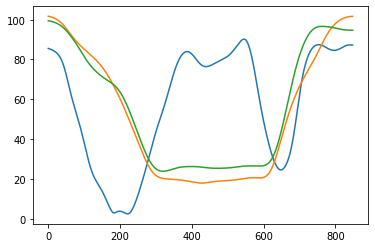

In [17]:
plt.plot(teste)

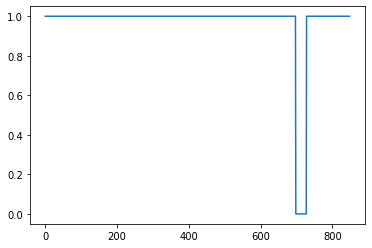

In [18]:
plt.plot(previsoes)

# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
classificador = RandomForestClassifier(n_estimators = 50, criterion = 'entropy')

In [33]:
classificador.fit(previsores, classes)

<ipython-input-33-05001fc67599>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classificador.fit(previsores, classes)


RandomForestClassifier(criterion='entropy', n_estimators=50)

In [34]:
previsoes = classificador.predict(teste)

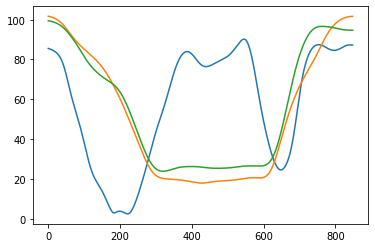

In [35]:
plt.plot(teste)

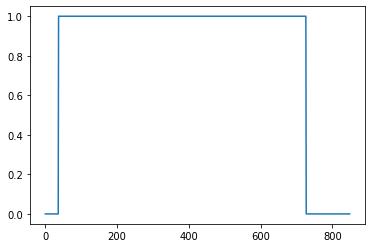

In [36]:
plt.plot(previsoes)

# Treinar com mais dados, então aplicar as informações do DTW em mais dados e aplicar no RNN e no Random Forest